In [119]:
import pandas as pd
import numpy as np
import math
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier as MLP
rand_state = 2022
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from util import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_raw = pd.read_csv('data/spaceship-titanic.csv').rename(columns={'Transported':'y'})
df_raw.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,y
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df_raw['y'].value_counts()

True     4378
False    4315
Name: y, dtype: int64

In [5]:
def preprocess(data_raw, cat_cols = [], num_cols = [], y_col = 'y', drop_cols = []):
    data = data_raw.copy()
    
    for c in cat_cols:
        data.loc[data[c].isnull(),c] = data[c].mode().values[0]
    for c in num_cols:
        data.loc[data[c].isnull(),c] = data[c].median()
    data = pd.get_dummies(data, columns=cat_cols, drop_first = True)
    scaler = MinMaxScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])
        
    return data.drop(columns=drop_cols)

In [6]:
data = preprocess(df_raw
                  , cat_cols = ['HomePlanet','CryoSleep','VIP','Destination']
                  , num_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
                  , drop_cols = ['PassengerId','Name','Cabin'])
data.head(5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,y,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,VIP_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,False,1,0,0,0,0,1
1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,True,0,0,0,0,0,1
2,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,False,1,0,0,1,0,1
3,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,False,1,0,0,0,0,1
4,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,True,0,0,0,0,0,1


In [88]:
X = data.drop(columns=['y'])
y = data['y']
ori_cols = X.columns

# Cluster

## K-means

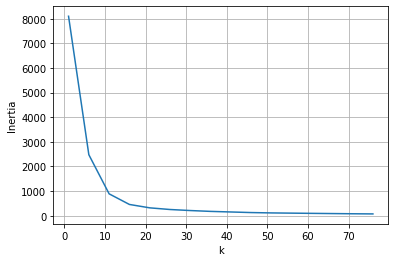

In [17]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [64]:
k = 2
k_means = KMeans(n_clusters=k, random_state=rand_state)
k_means.fit(X)
stat, p, dof, expected = chi2_contingency(pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                                                     ,axis=1).groupby(['y','k_means_label'], as_index=False).count().pivot(index='y',columns='k_means_label',values='index').fillna(0).values)
print(p)
contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                                                     ,axis=1).groupby(['y','k_means_label'], as_index=False).count().pivot(index='y',columns='k_means_label',values='index').fillna(0)
print(contigency_matrix)

3.337391197718458e-19
k_means_label     0     1
y                        
False          3218  1097
True           2879  1499


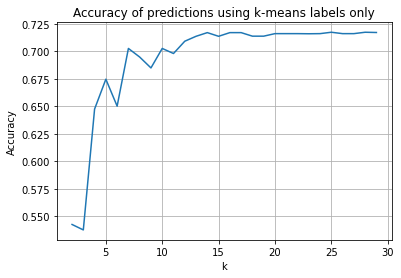

In [77]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

## Expectation Maximization

In [79]:
from sklearn.mixture import GaussianMixture

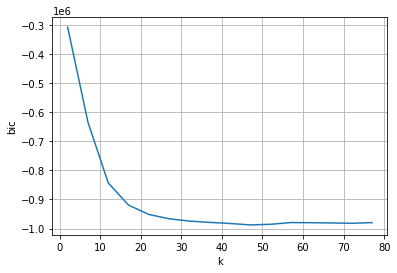

In [83]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X)
    res.append(gmm.bic(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

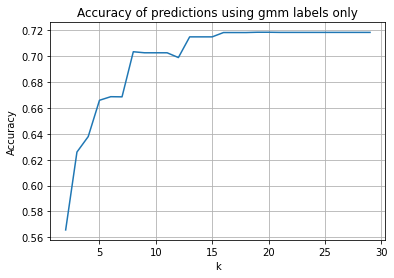

In [89]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

# Dimensionality Reduction

## PCA

In [121]:
from sklearn.decomposition import FastICA, PCA,TruncatedSVD
from numpy.linalg import eig

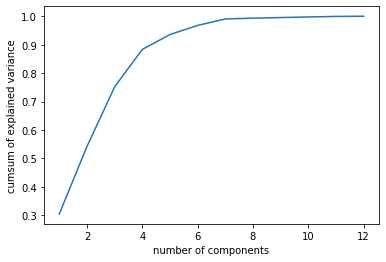

In [106]:
pca = PCA().fit(X)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumsum of explained variance')
plt.show()

In [107]:
eig(pca.get_covariance())

(array([0.28416501, 0.22091405, 0.19560432, 0.12273249, 0.04883241,
        0.02991682, 0.02114821, 0.00060274, 0.00251991, 0.00208517,
        0.00177016, 0.00189537]),
 array([[-1.48907347e-02, -5.41257816e-02, -6.06295757e-02,
          1.14665974e-01, -1.88704599e-01,  9.67525175e-01,
          8.90412456e-02, -2.37807138e-03, -1.16721621e-02,
         -7.44907115e-03, -1.21811543e-02,  5.99487538e-03],
        [ 1.97428403e-02, -9.46274047e-03,  1.06534868e-02,
          3.13462115e-02, -2.45436653e-03,  7.97249144e-03,
         -2.80381909e-03,  3.63271514e-02, -2.39242479e-01,
          1.16171409e-01,  7.94525460e-01, -5.43161137e-01],
        [-1.18952548e-02, -3.92477223e-02, -2.06338540e-02,
          2.94657699e-02, -1.00934442e-02,  4.38745234e-04,
         -1.43199284e-02,  4.16123317e-02,  7.56924110e-01,
         -4.63430338e-01, -1.83583828e-02, -4.54913836e-01],
        [ 6.74458859e-03, -6.93874325e-03,  3.72503590e-03,
          9.68612313e-03, -1.71101938e-03, -5.5

### pca + k-means

In [136]:
X0 = PCA(2).fit_transform(X)

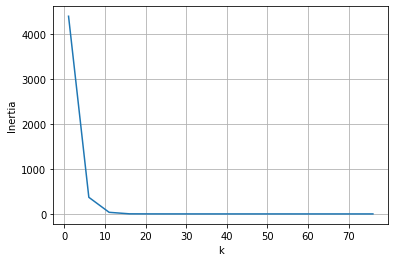

In [138]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

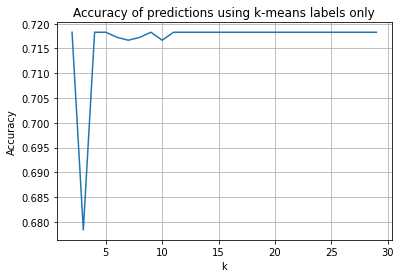

In [139]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### PCA + EM

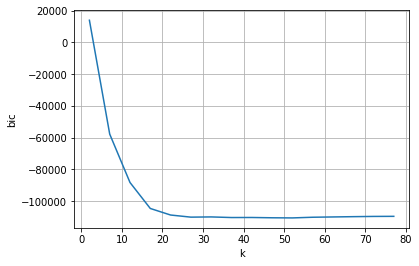

In [140]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

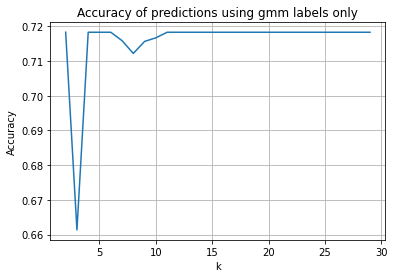

In [141]:
ks = range(2,30,1)
res = []
X0 = PCA(2).fit_transform(X)
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

## ICA

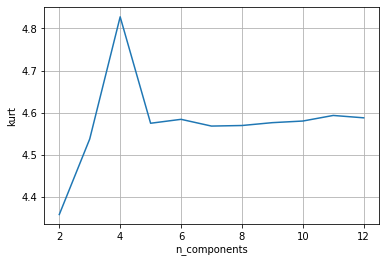

In [117]:
res = []
ks = range(2,13,1)
for k in ks:
    ica = FastICA(n_components = k, random_state=rand_state)
    tmp_df = pd.DataFrame(ica.fit_transform(X))
    #res.append(tmp_df.kurt(axis=0).abs().mean())
    res.append(abs(np.min(tmp_df.kurt(axis=0) -3)))
plt.plot(ks,res)
plt.xlabel('n_components')
plt.ylabel('kurt')
plt.grid()
plt.show()

### ica + k-means

In [147]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)

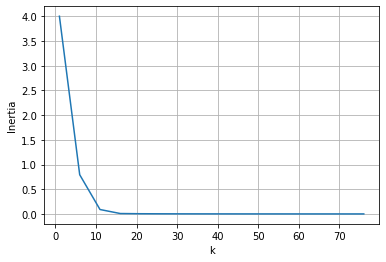

In [143]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

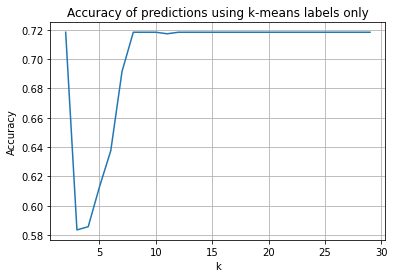

In [144]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### ica+EM

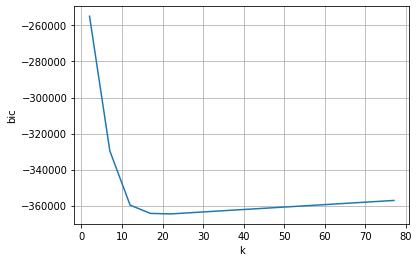

In [145]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

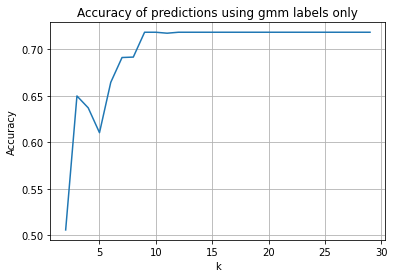

In [148]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

## Randomized Projections

In [118]:
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

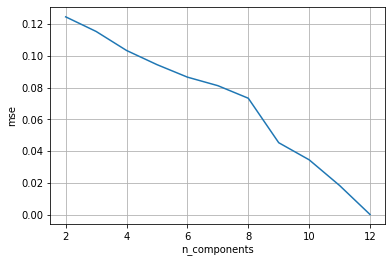

In [120]:
res = []
ks = range(2,13,1)
for k in ks:
    grp = GaussianRandomProjection(n_components = k, random_state=rand_state)
    X1 = grp.fit_transform(X)
    X_hat = X1.dot(np.linalg.pinv(grp.components_.T))
    res.append(metrics.mean_squared_error(X, X_hat))
plt.plot(ks,res)
plt.xlabel('n_components')
plt.ylabel('mse')
plt.grid()
plt.show()

### GRP + k-means

In [149]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)

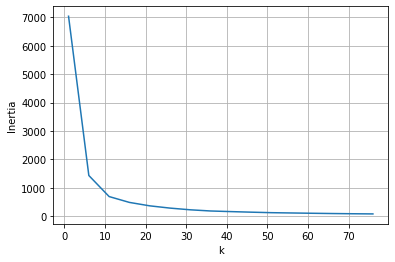

In [150]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

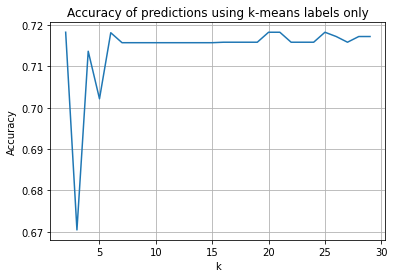

In [151]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### grp + em

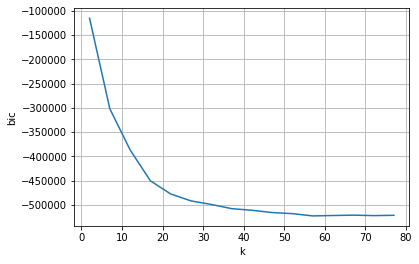

In [152]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

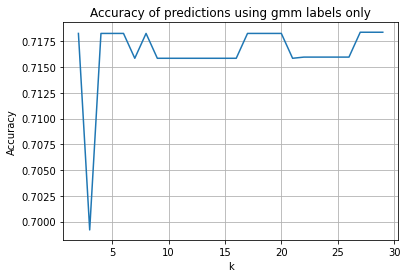

In [153]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

## svd 

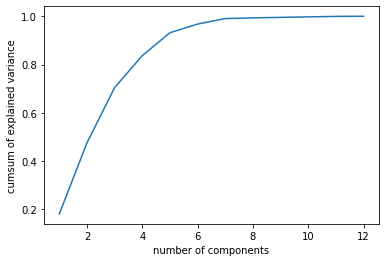

In [124]:
svd = TruncatedSVD(12).fit(X)
plt.plot(range(1, len(svd.explained_variance_ratio_) + 1), np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumsum of explained variance')
plt.show()

### svd + k-means

In [156]:
X0 = TruncatedSVD(2).fit_transform(X)

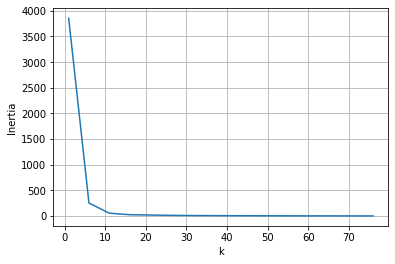

In [157]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

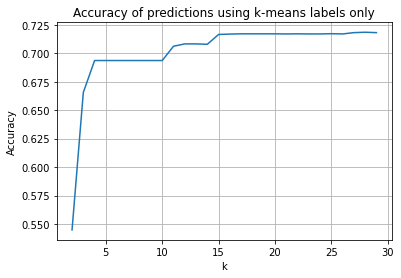

In [158]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### svd + em

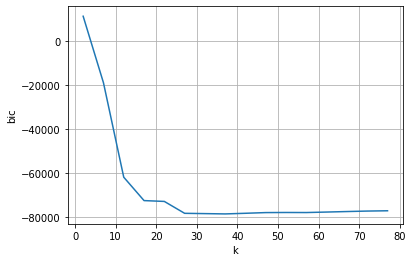

In [159]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

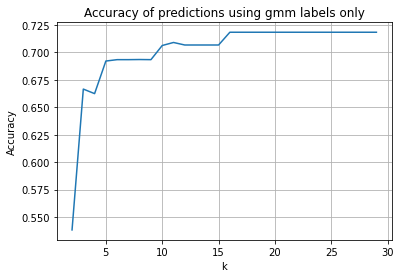

In [160]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

In [161]:
data

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,y,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,VIP_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,False,1,0,0,0,0,1
1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,True,0,0,0,0,0,1
2,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,False,1,0,0,1,0,1
3,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,False,1,0,0,0,0,1
4,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,True,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.518987,0.000000,0.228726,0.000000,0.073322,0.003066,False,1,0,0,1,0,0
8689,0.227848,0.000000,0.000000,0.000000,0.000000,0.000000,False,0,0,1,0,1,0
8690,0.329114,0.000000,0.000000,0.079687,0.000045,0.000000,True,0,0,0,0,0,1
8691,0.405063,0.000000,0.035186,0.000000,0.015753,0.134049,False,1,0,0,0,0,0


## dr + NN 

### pca + NN

train roc_auc score: [0.74967136 0.7698134  0.76890209 0.76845999 0.76657982]
test roc_auc score: [0.7481764  0.76941516 0.76614949 0.7651319  0.76423329]


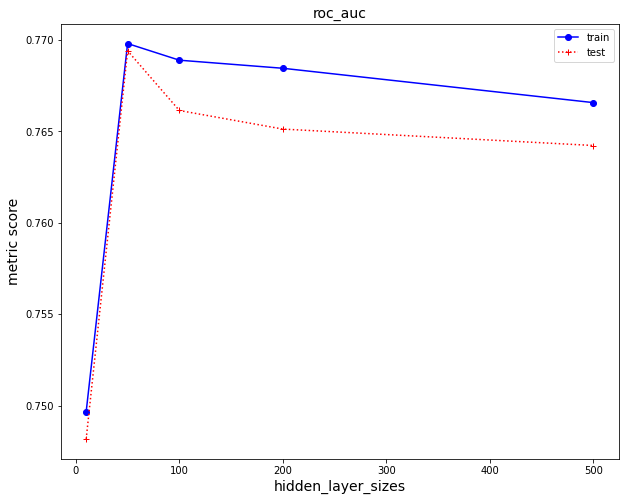

train neg_log_loss score: [-0.58061822 -0.55046896 -0.54950812 -0.54828215 -0.54663408]
test neg_log_loss score: [-0.58192983 -0.55409827 -0.55261629 -0.5511127  -0.54944708]


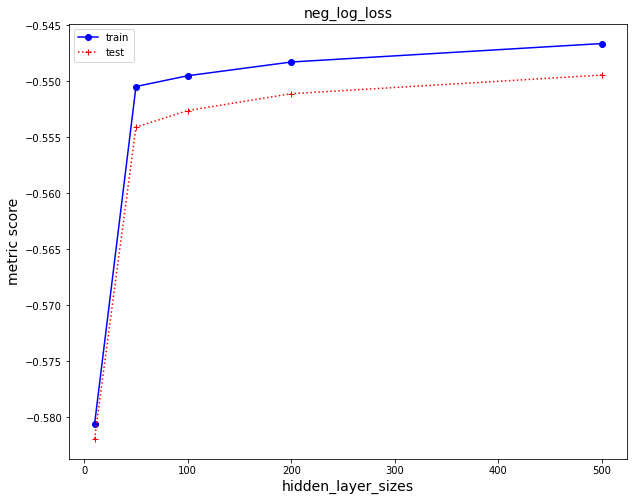

train accuracy score: [0.71347627 0.71652498 0.71707138 0.71744521 0.71727264]
test accuracy score: [0.71391075 0.71551981 0.71667102 0.71759103 0.71747602]


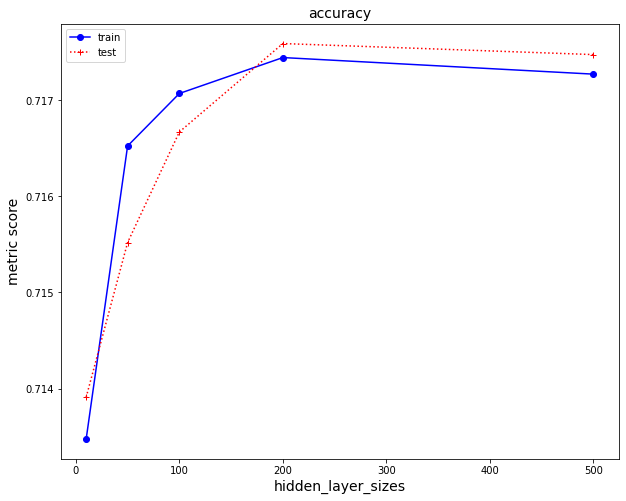

mean fit time: [0.51685104 4.7972785  5.34941258 5.66545792 9.09221249]


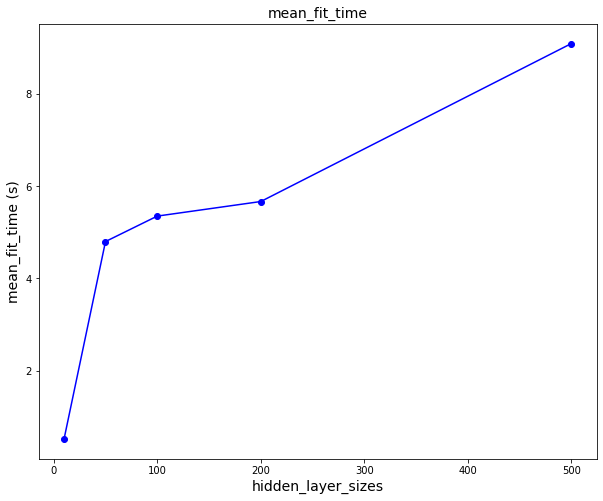

In [165]:
X0 = PCA(2).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

train roc_auc score: [0.78708743 0.79378856 0.7995049  0.80447319 0.81084361]
test roc_auc score: [0.78026986 0.78541986 0.78752737 0.79210698 0.79567904]


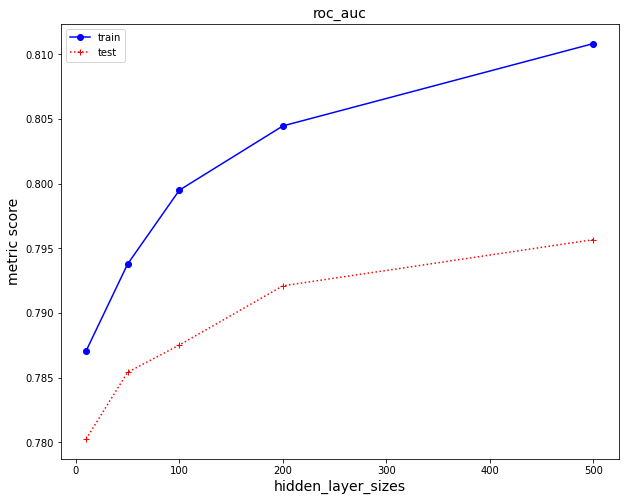

train neg_log_loss score: [-0.53026891 -0.52282618 -0.51704232 -0.51277298 -0.50700558]
test neg_log_loss score: [-0.5364604  -0.53092737 -0.52835219 -0.52394436 -0.52225367]


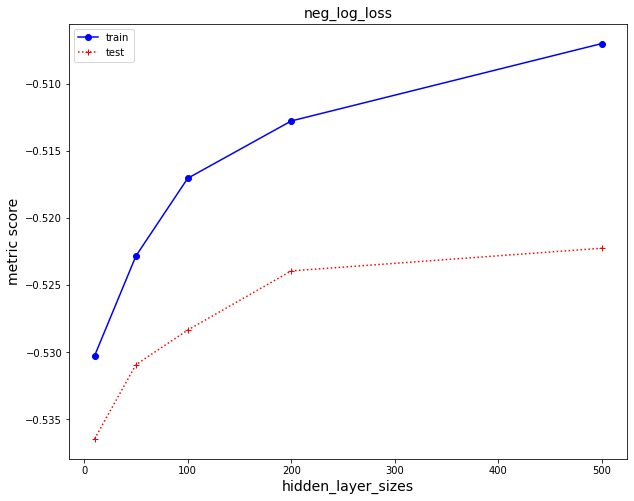

train accuracy score: [0.73395287 0.73803655 0.7388418  0.74065359 0.74430594]
test accuracy score: [0.73058971 0.73404176 0.73473148 0.73726246 0.73657254]


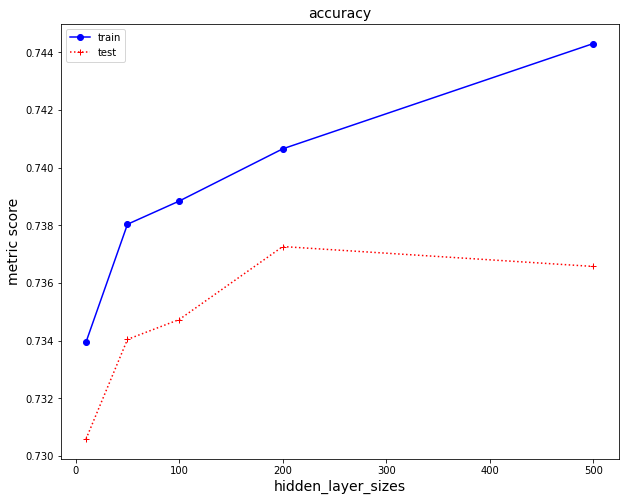

mean fit time: [ 1.41736741  2.37142553  4.2450367   7.57656522 15.89464841]


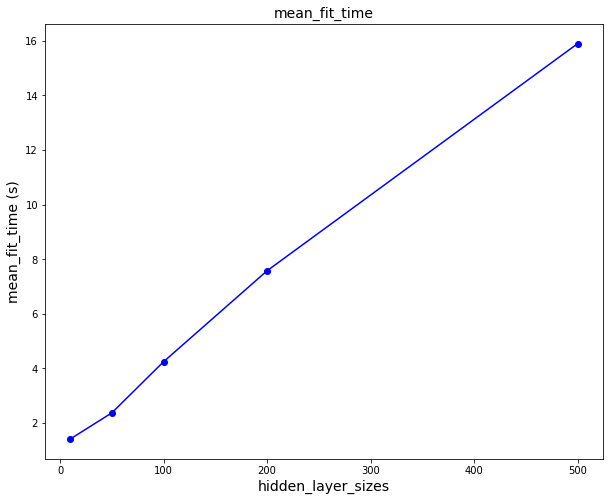

In [171]:
X0 = PCA(8).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### ica+NN

train roc_auc score: [0.75566882 0.75220355 0.7563451  0.75917164 0.76691109]
test roc_auc score: [0.75507153 0.75190148 0.75394421 0.755231   0.76705529]


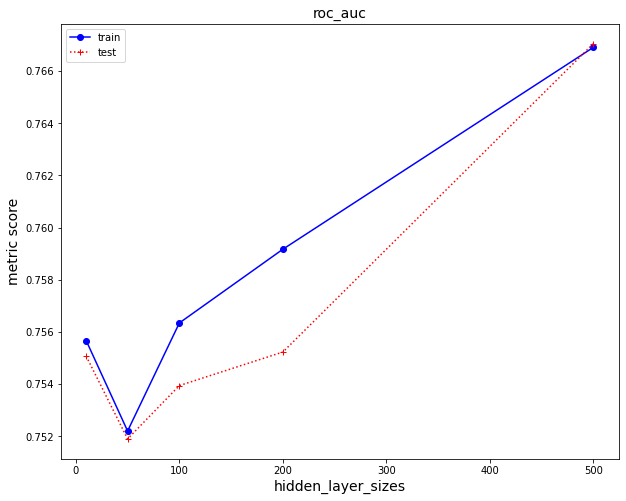

train neg_log_loss score: [-0.56416435 -0.56699794 -0.56403123 -0.5595188  -0.55073582]
test neg_log_loss score: [-0.56535391 -0.56957914 -0.56668478 -0.56102588 -0.55473869]


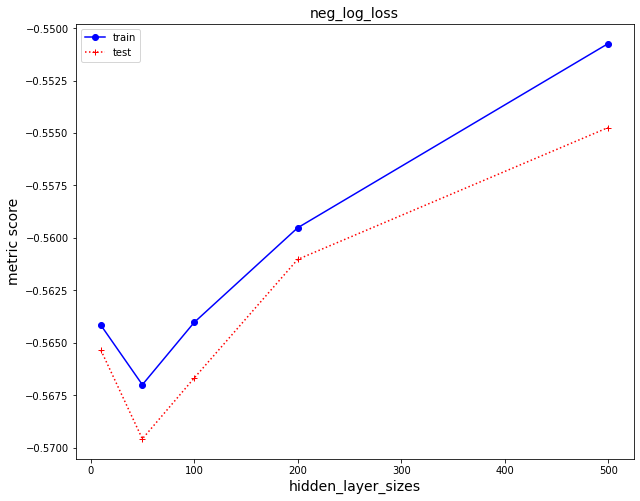

train accuracy score: [0.7116068  0.71022689 0.71088808 0.71433933 0.71833674]
test accuracy score: [0.71333597 0.71057186 0.71287382 0.71195382 0.71816627]


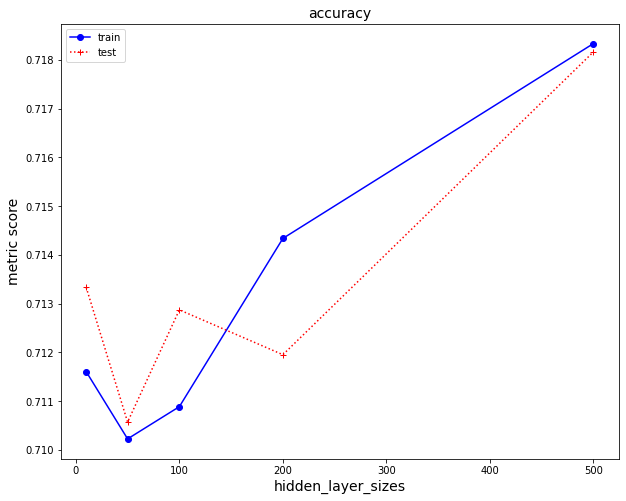

mean fit time: [2.03778148 1.45956807 2.11514192 3.29241176 8.17144237]


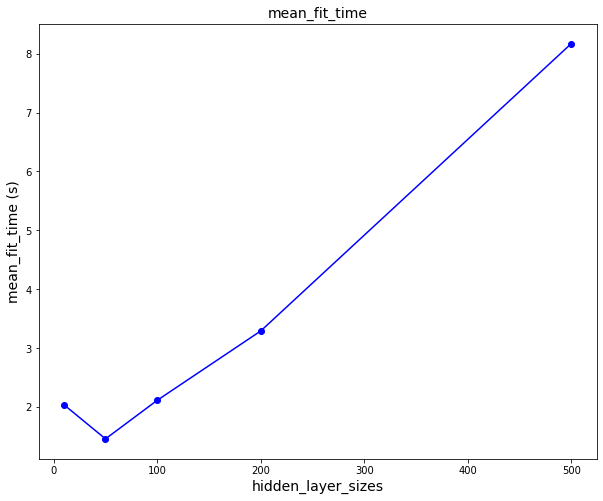

In [167]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### GRP+NN

train roc_auc score: [0.85132574 0.86816922 0.87021941 0.87221639 0.87395837]
test roc_auc score: [0.84724468 0.86446574 0.86556479 0.86722611 0.86784101]


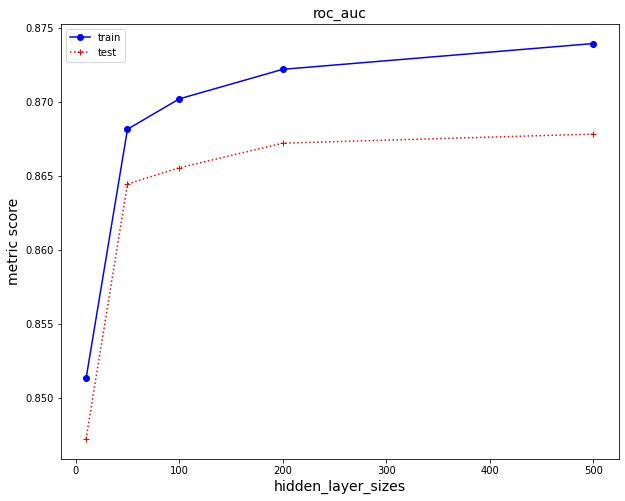

train neg_log_loss score: [-0.48026974 -0.45301153 -0.44990361 -0.44599799 -0.44396424]
test neg_log_loss score: [-0.48770424 -0.46137271 -0.45896946 -0.4588871  -0.45659263]


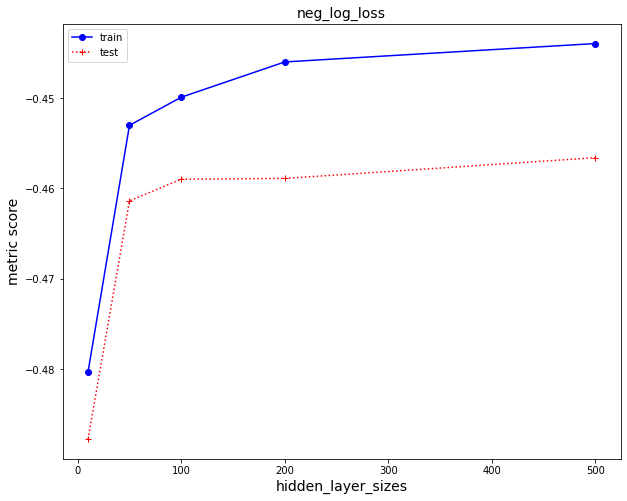

train accuracy score: [0.76550085 0.77959285 0.78068565 0.78341778 0.78767395]
test accuracy score: [0.76521565 0.77510778 0.77602825 0.77821334 0.78315944]


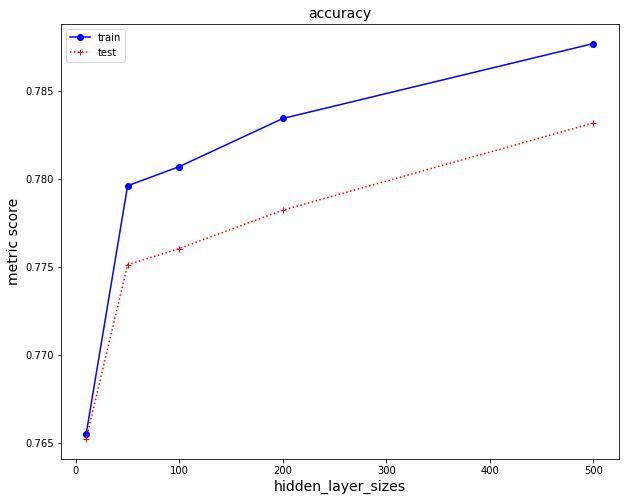

mean fit time: [ 5.26004233  5.83226728  6.73897276  8.28293877 13.9166482 ]


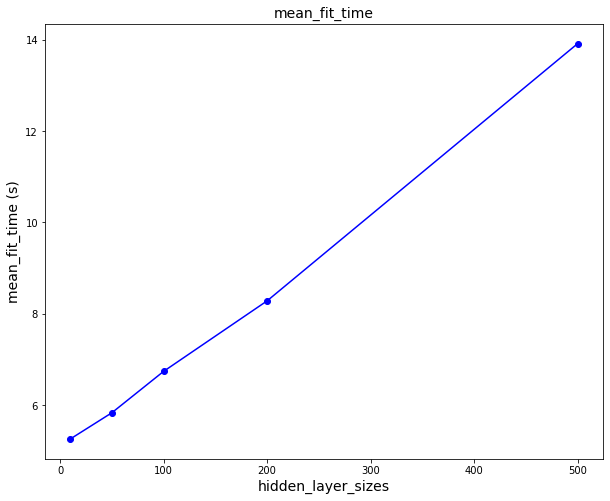

In [168]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### SVD + NN

train roc_auc score: [0.74063139 0.76016437 0.76161138 0.76732235 0.76867652]
test roc_auc score: [0.74214917 0.75561255 0.7572214  0.76399037 0.76554394]


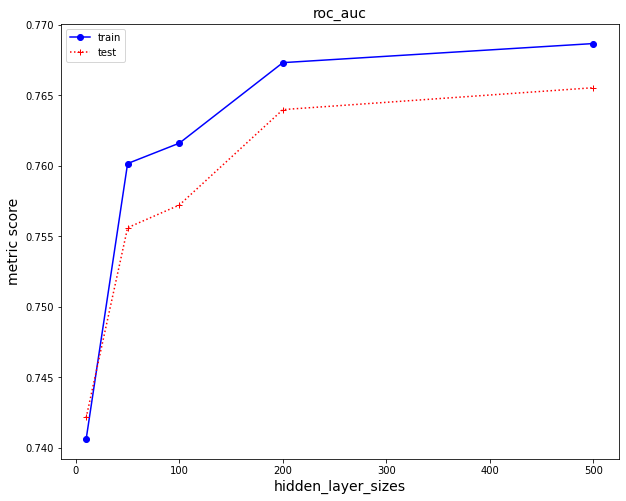

train neg_log_loss score: [-0.57670672 -0.56347969 -0.5608764  -0.55608138 -0.55470118]
test neg_log_loss score: [-0.5765983  -0.56576877 -0.56431629 -0.55880457 -0.55851236]


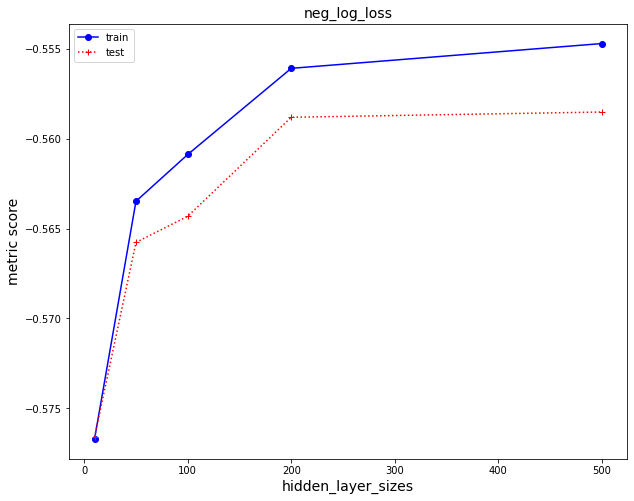

train accuracy score: [0.69786028 0.70205915 0.70496374 0.710313   0.71192354]
test accuracy score: [0.6995303  0.70125603 0.70562781 0.70919242 0.70850223]


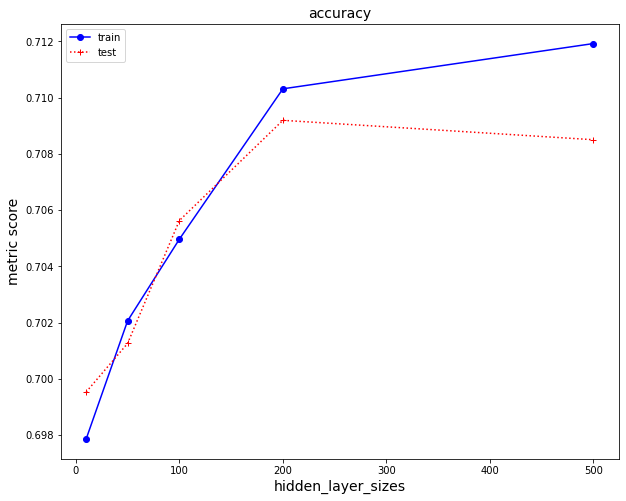

mean fit time: [1.39783964 2.49695868 2.89642382 5.03550544 8.57539997]


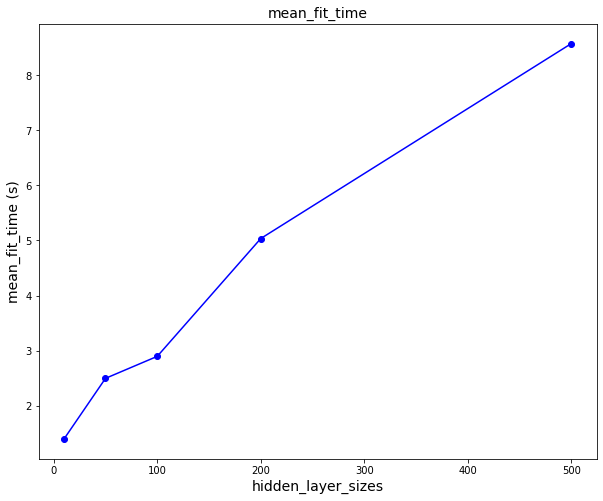

In [169]:
X0 = TruncatedSVD(2).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

train roc_auc score: [0.7832414  0.79342811 0.80115175 0.80489626 0.8101271 ]
test roc_auc score: [0.77743167 0.78591548 0.79005792 0.7910933  0.79257998]


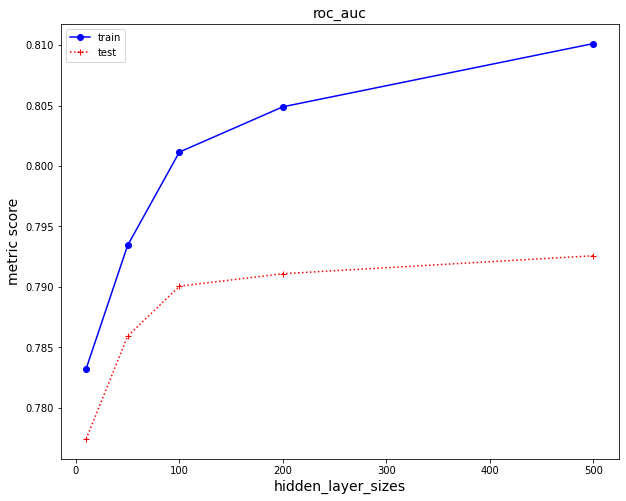

train neg_log_loss score: [-0.53397348 -0.52306585 -0.51594672 -0.51303773 -0.50918078]
test neg_log_loss score: [-0.53970812 -0.53044044 -0.52583258 -0.52484253 -0.52416392]


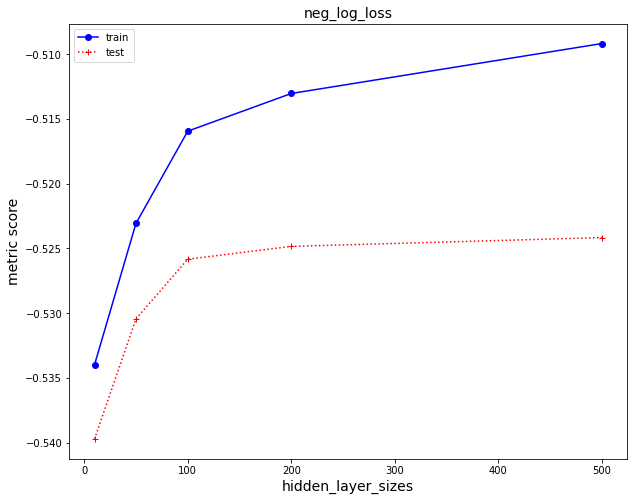

train accuracy score: [0.72892015 0.7381228  0.73987706 0.74088363 0.74223527]
test accuracy score: [0.72587251 0.73530699 0.73553674 0.73634193 0.7341567 ]


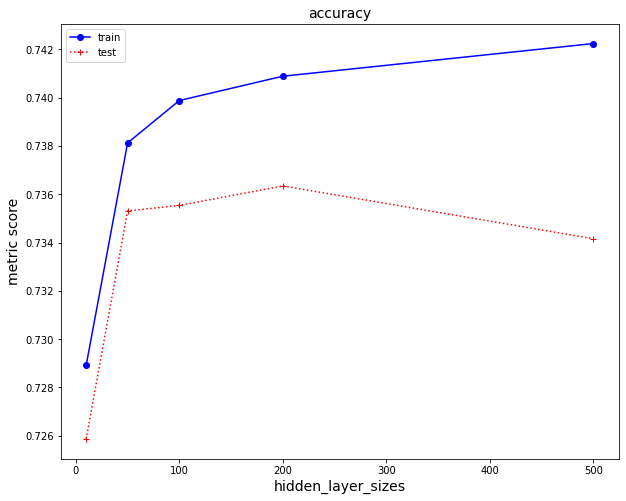

mean fit time: [ 1.36349268  2.55174866  5.44648209  8.12818341 15.91179295]


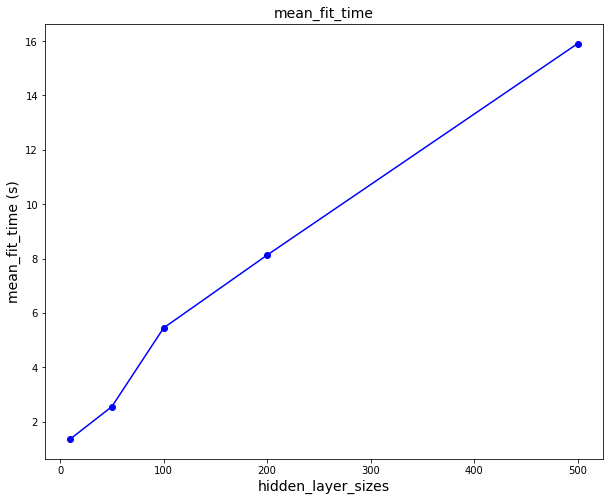

In [172]:
X0 = TruncatedSVD(8).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

## dr + cluster + NN

### pca + k-means + nn

train roc_auc score: [0.75378999 0.76816097 0.76602063 0.76640275 0.76465405]
test roc_auc score: [0.7504767  0.76561179 0.76376479 0.76448333 0.76126299]


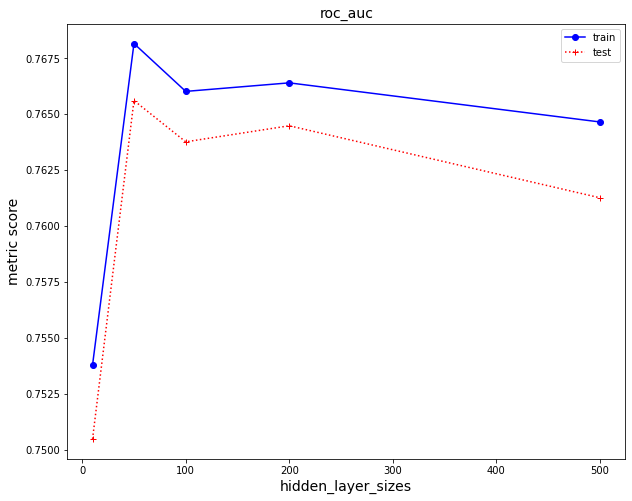

train neg_log_loss score: [-0.56602578 -0.54742414 -0.54585491 -0.54602986 -0.54580495]
test neg_log_loss score: [-0.5721837  -0.55039731 -0.54883459 -0.54859281 -0.54821967]


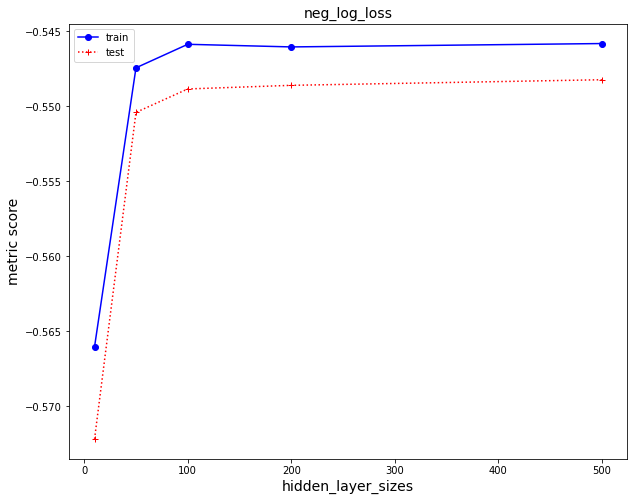

train accuracy score: [0.71830797 0.71830797 0.71836549 0.71833673 0.71830798]
test accuracy score: [0.71805119 0.71816627 0.71793612 0.71816627 0.71816633]


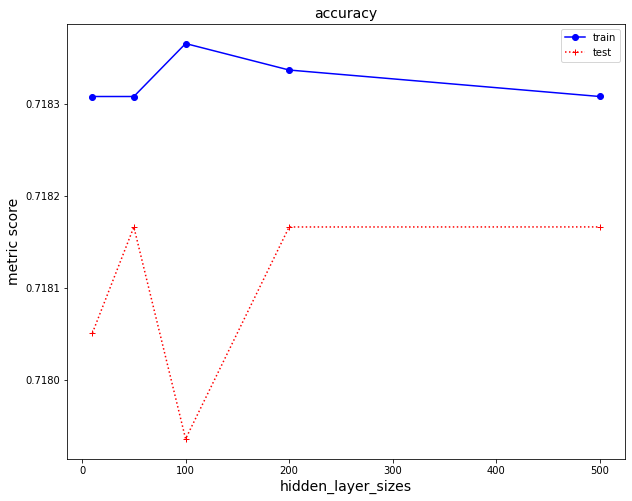

mean fit time: [1.9130177  3.66320081 3.63187261 4.11299944 6.33610711]


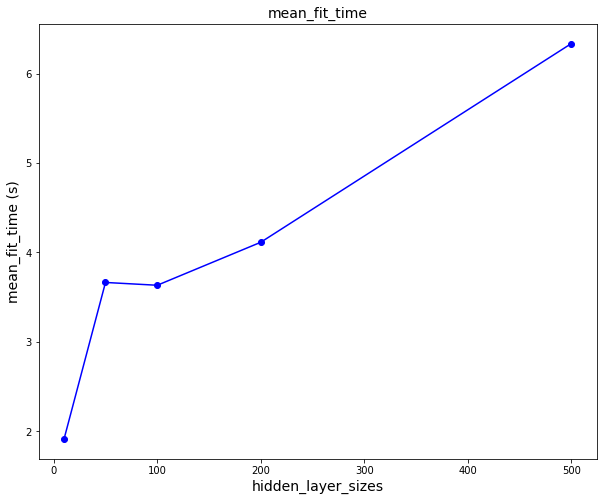

In [193]:
X0 = PCA(2).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

train roc_auc score: [0.78592793 0.79654172 0.79669365 0.80461033 0.81051295]
test roc_auc score: [0.77927711 0.78876851 0.78636071 0.79088077 0.79320376]


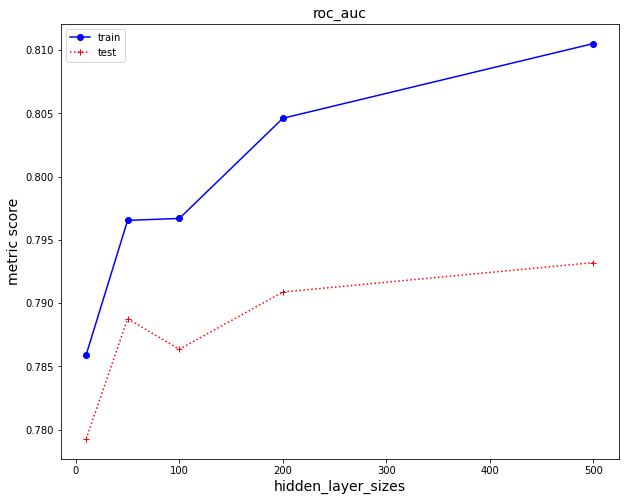

train neg_log_loss score: [-0.53233869 -0.51961263 -0.51922417 -0.51235303 -0.50722618]
test neg_log_loss score: [-0.53840331 -0.52748086 -0.52865983 -0.52395506 -0.52312614]


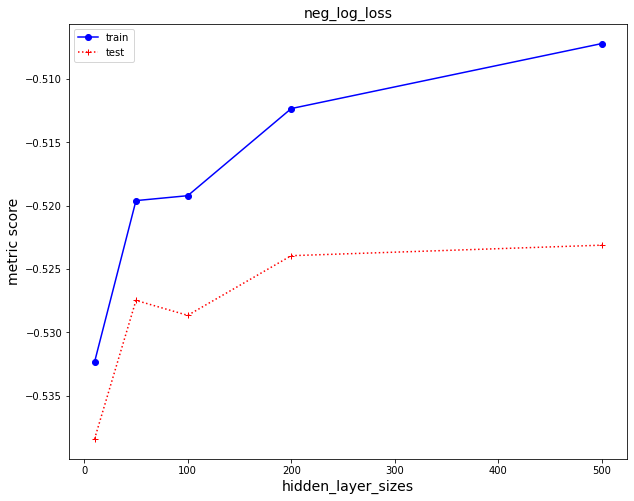

train accuracy score: [0.73274511 0.73800775 0.73820911 0.74016476 0.74304052]
test accuracy score: [0.73024456 0.73542193 0.73392622 0.73565201 0.73450166]


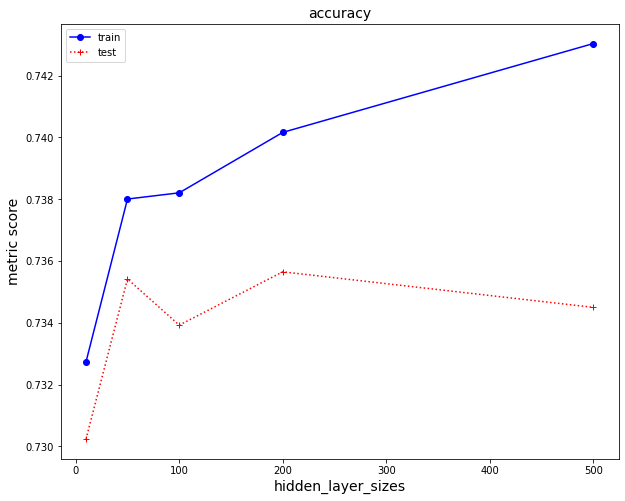

mean fit time: [ 1.49100938  3.65180058  3.67239966  7.83771129 15.58631701]


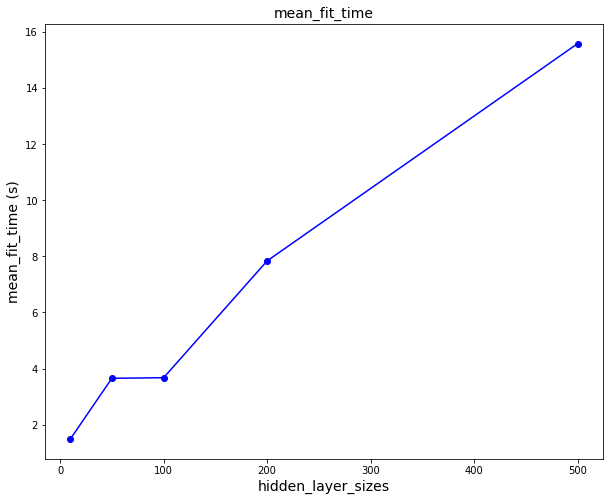

In [192]:
X0 = PCA(8).fit_transform(X)
clf = KMeans(n_clusters=6, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### pca + em + nn

train roc_auc score: [0.75262233 0.76718465 0.76646063 0.76521247 0.76577428]
test roc_auc score: [0.75011484 0.76407191 0.76346791 0.7617631  0.76482537]


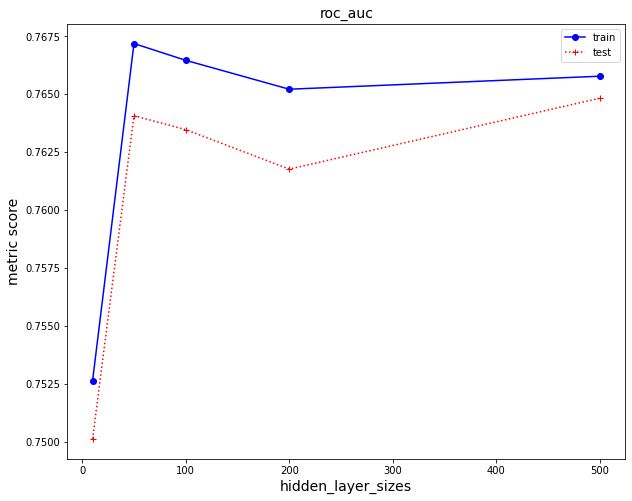

train neg_log_loss score: [-0.56676819 -0.54774951 -0.54575304 -0.54577946 -0.54565572]
test neg_log_loss score: [-0.5727566  -0.5509797  -0.54896227 -0.54911024 -0.5489236 ]


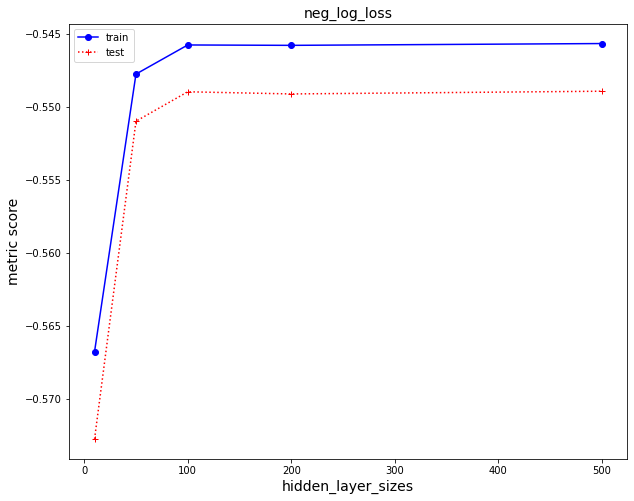

train accuracy score: [0.71827922 0.71827922 0.71830797 0.71830798 0.71830797]
test accuracy score: [0.71828134 0.71816627 0.71816627 0.71828134 0.71793612]


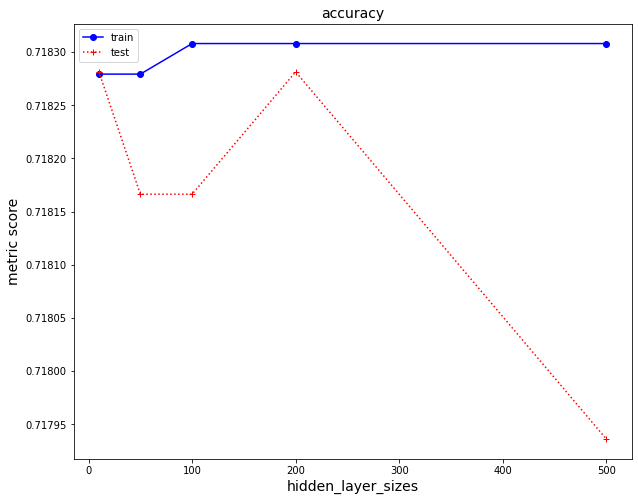

mean fit time: [1.39640498 3.96459956 3.48891106 4.04639926 6.53039932]


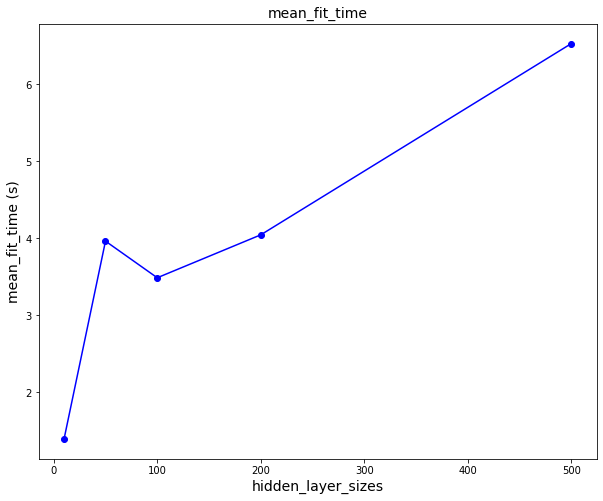

In [195]:
X0 = PCA(2).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### ica + kmeans+nn

train roc_auc score: [0.74854193 0.75562111 0.75459341 0.75519372 0.75544524]
test roc_auc score: [0.74697573 0.754921   0.75309037 0.75395718 0.75491548]


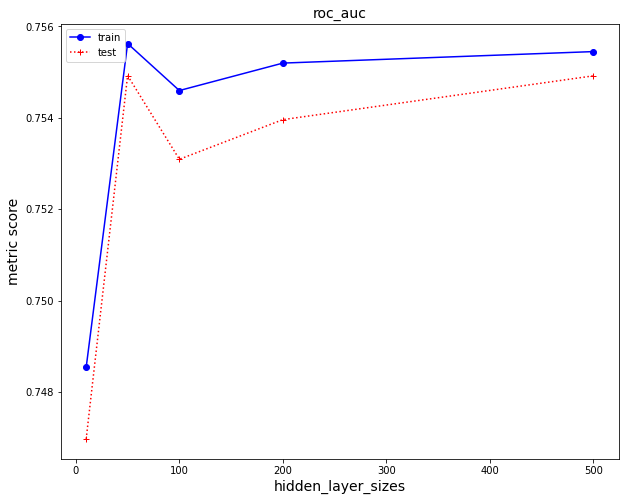

train neg_log_loss score: [-0.56403387 -0.54806929 -0.5476448  -0.54738156 -0.54751785]
test neg_log_loss score: [-0.56971609 -0.5507039  -0.55016514 -0.54964292 -0.55062342]


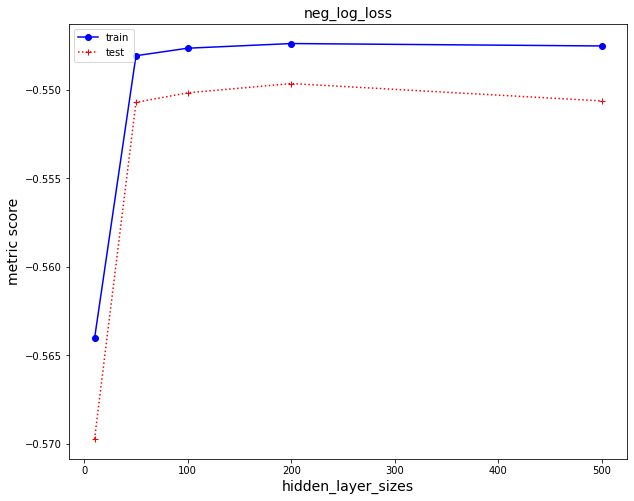

train accuracy score: [0.71767525 0.71827922 0.71827922 0.71827922 0.71827922]
test accuracy score: [0.71816633 0.71828134 0.71828134 0.71828134 0.71828134]


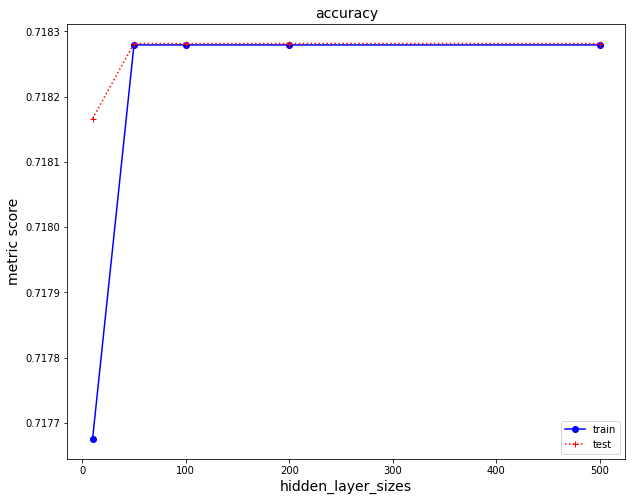

mean fit time: [2.02341547 3.41219945 3.38301167 3.86819911 5.30580001]


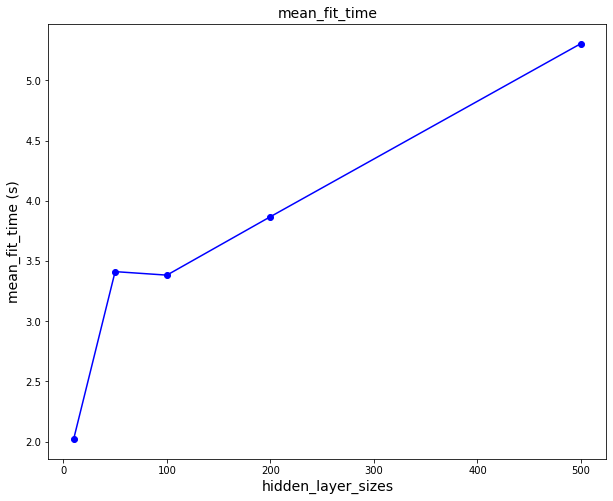

In [196]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### ica + em + nn

train roc_auc score: [0.75755318 0.76546182 0.76142567 0.76704393 0.76547984]
test roc_auc score: [0.75395234 0.76203613 0.75862216 0.76359925 0.76329933]


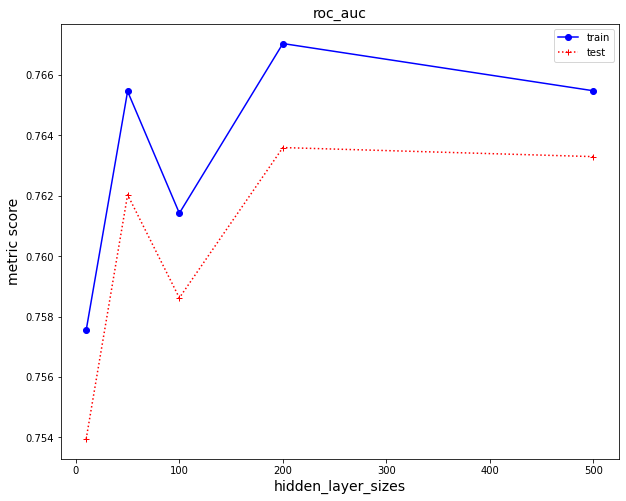

train neg_log_loss score: [-0.55856457 -0.5539125  -0.55411422 -0.54929581 -0.54805163]
test neg_log_loss score: [-0.56052362 -0.55716416 -0.55894386 -0.55172779 -0.54969894]


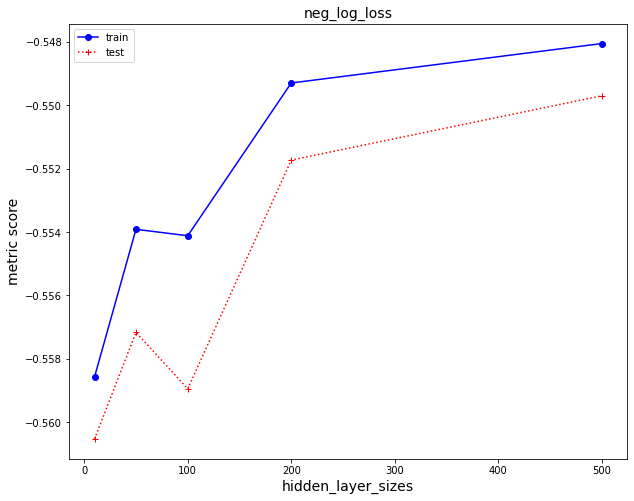

train accuracy score: [0.71333283 0.71548947 0.71563327 0.71810668 0.71629503]
test accuracy score: [0.71172387 0.71724587 0.71782118 0.71793612 0.71459895]


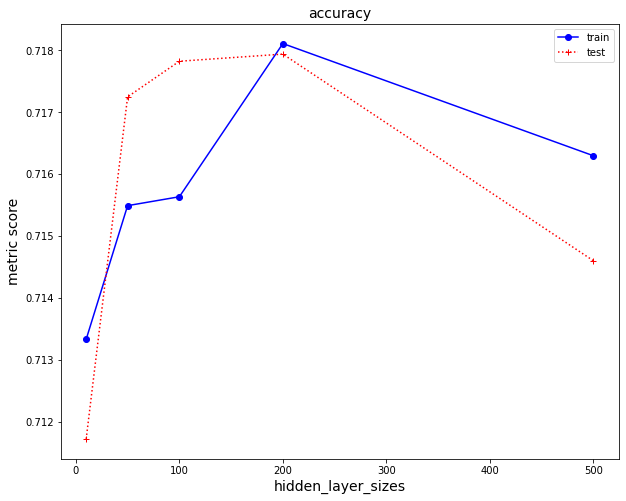

mean fit time: [2.80673022 3.42139916 4.19399977 6.23081231 8.38471808]


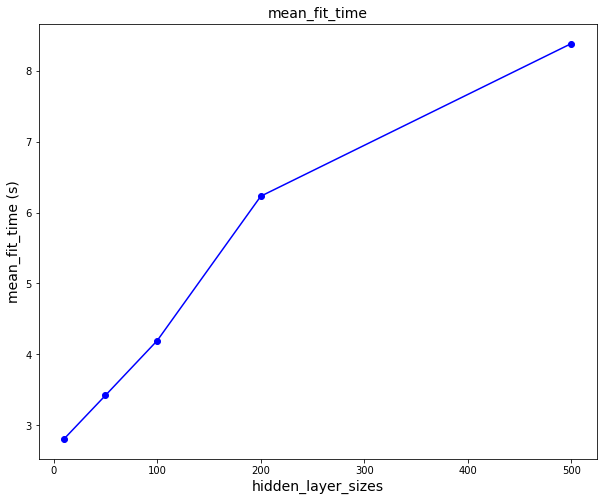

In [197]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### grp + kmeans+nn

train roc_auc score: [0.8537587  0.86862614 0.87023893 0.87117792 0.87201006]
test roc_auc score: [0.85097775 0.86469612 0.86619157 0.86600854 0.86678279]


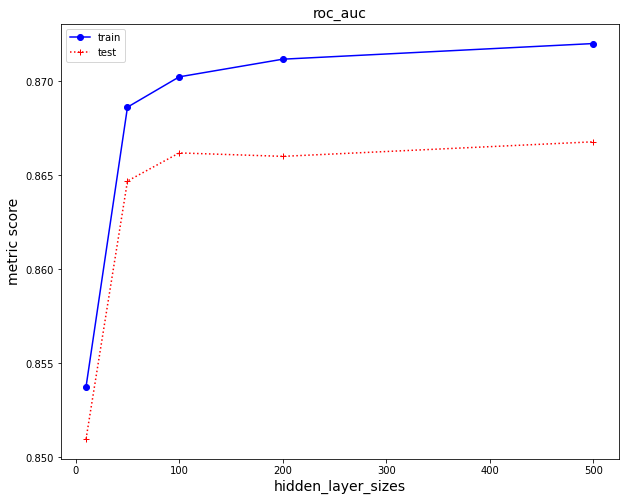

train neg_log_loss score: [-0.47424029 -0.45309133 -0.45087416 -0.44843229 -0.44674332]
test neg_log_loss score: [-0.48069934 -0.46144547 -0.45978808 -0.45883069 -0.45690368]


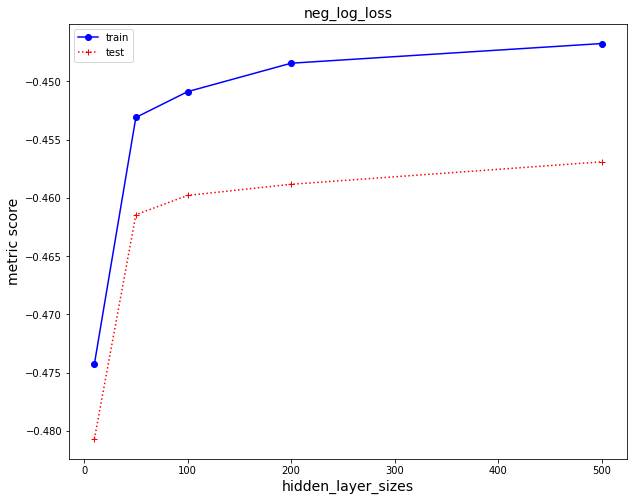

train accuracy score: [0.76998737 0.77898895 0.78149098 0.78146222 0.78195098]
test accuracy score: [0.76901252 0.77476222 0.77706253 0.77384196 0.77384169]


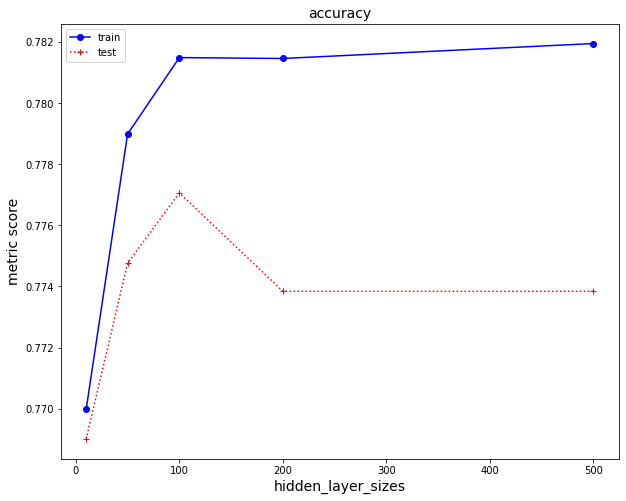

mean fit time: [ 6.38261018  6.37859945  5.8674942   6.8085897  11.42882614]


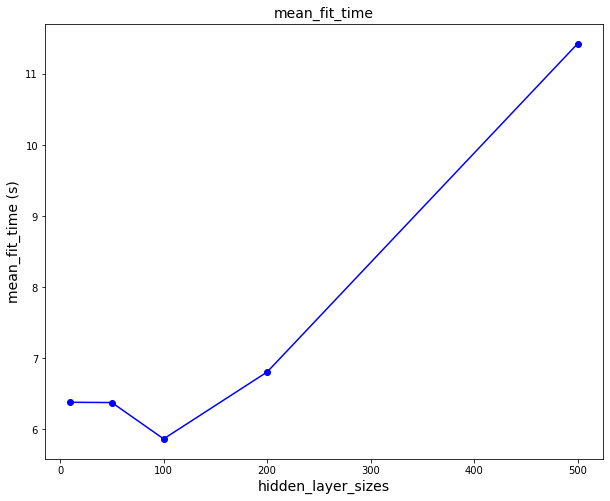

In [198]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### grp + em + nn

train roc_auc score: [0.85684754 0.86903306 0.86964547 0.87137562 0.87244265]
test roc_auc score: [0.85418689 0.86379498 0.8645642  0.86695168 0.86682198]


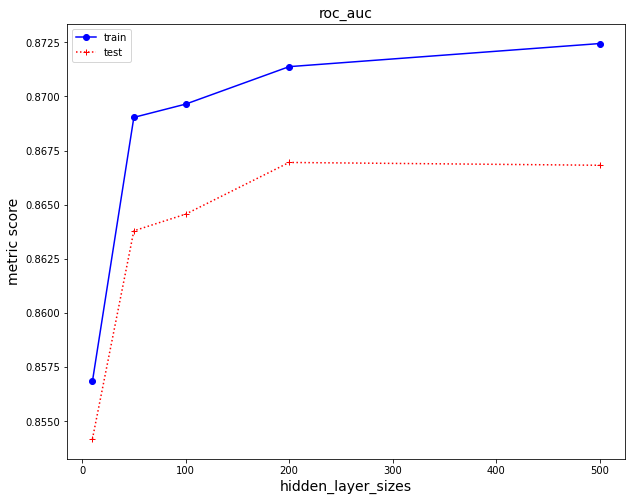

train neg_log_loss score: [-0.47159601 -0.4528162  -0.45092294 -0.44770985 -0.44825555]
test neg_log_loss score: [-0.47704169 -0.46135791 -0.46128055 -0.45665164 -0.45673286]


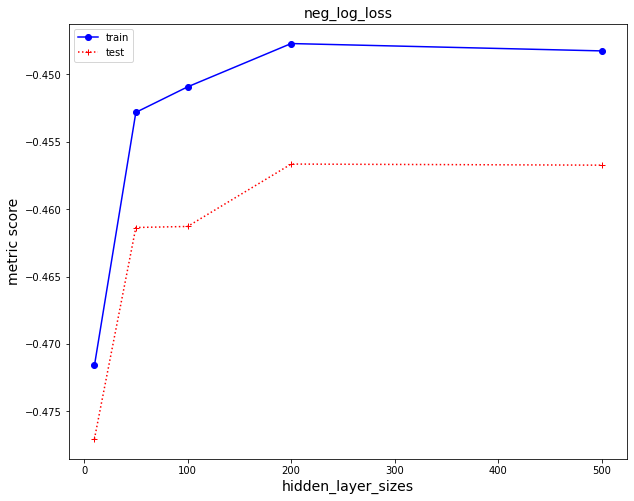

train accuracy score: [0.76909617 0.77890274 0.77847134 0.78209474 0.78301525]
test accuracy score: [0.76624781 0.77487763 0.77556682 0.77683357 0.78062833]


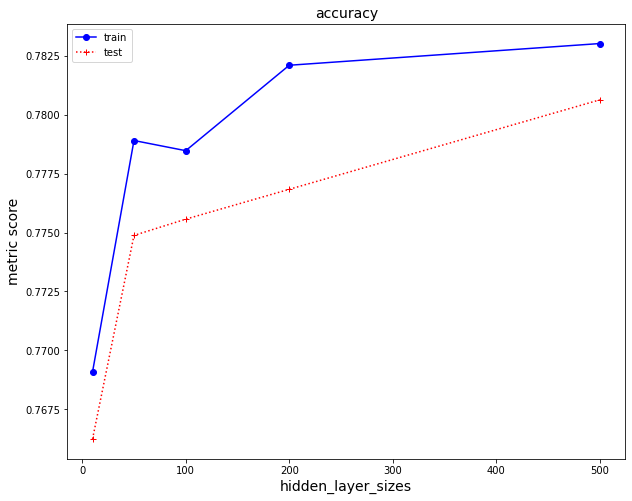

mean fit time: [ 5.97971683  5.75589466  5.51217246  7.2324862  12.49668317]


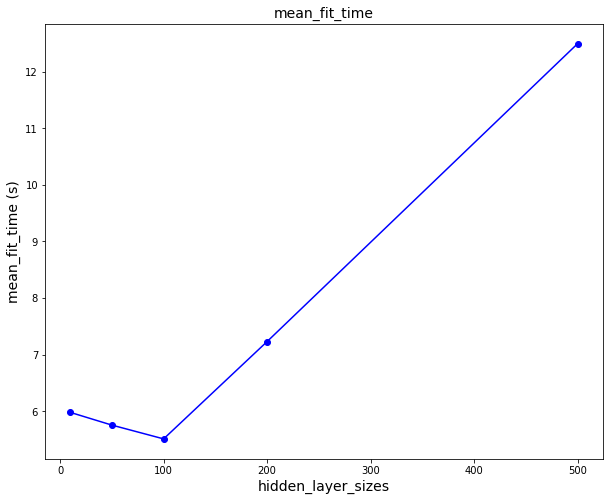

In [199]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### svd + kmeans+nn

train roc_auc score: [0.75534995 0.76662157 0.76753551 0.77162984 0.77359574]
test roc_auc score: [0.75088383 0.76346371 0.76373695 0.76891661 0.7705935 ]


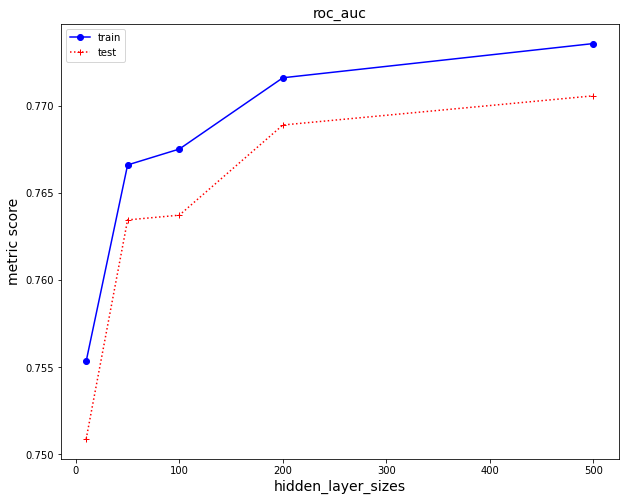

train neg_log_loss score: [-0.56615611 -0.55607219 -0.55528168 -0.55204202 -0.54987448]
test neg_log_loss score: [-0.5675674  -0.5584759  -0.55783566 -0.55534455 -0.55341238]


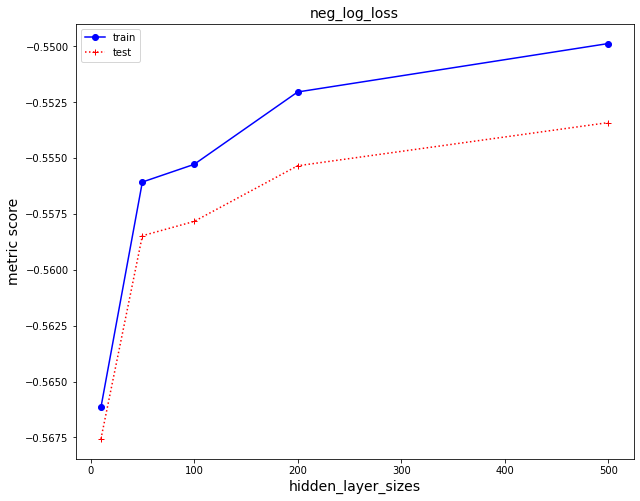

train accuracy score: [0.70493477 0.71028423 0.71019795 0.71465575 0.71681282]
test accuracy score: [0.70620266 0.70792693 0.70873238 0.7102275  0.71609366]


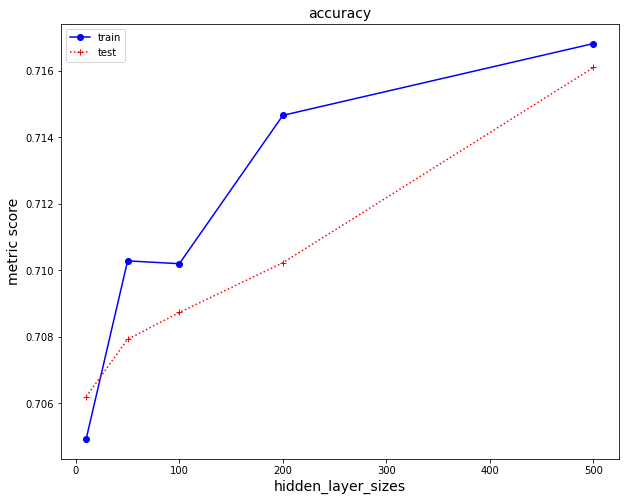

mean fit time: [2.33535404 2.85563521 2.76082606 4.57636561 8.81158905]


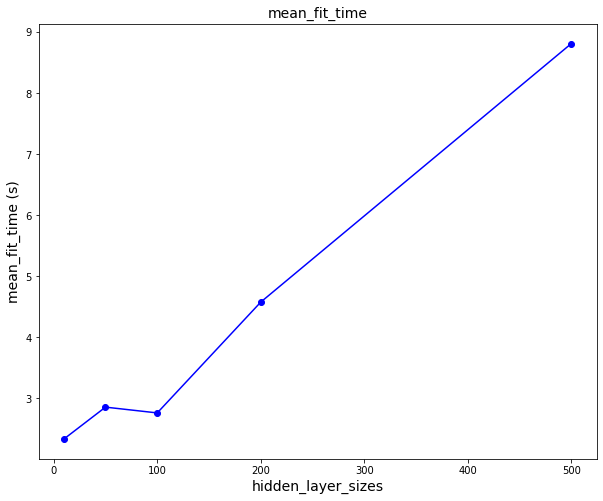

In [201]:
X0 = TruncatedSVD(2).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### svd + em + nn

train roc_auc score: [0.75804672 0.76791784 0.76775962 0.77116746 0.77295134]
test roc_auc score: [0.75828999 0.76586195 0.76427271 0.76717021 0.76831248]


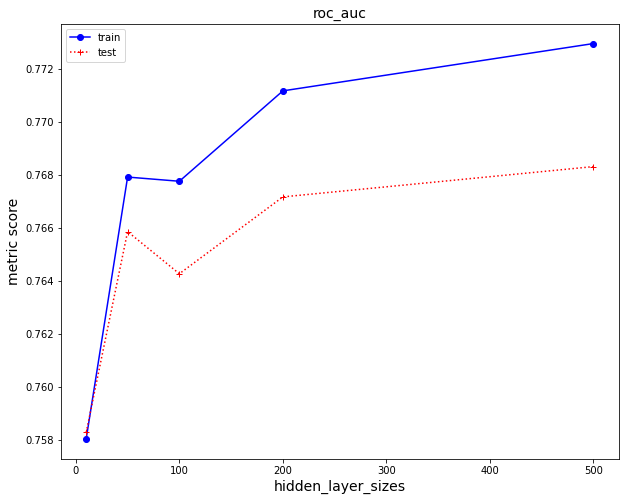

train neg_log_loss score: [-0.56234679 -0.55410079 -0.55508402 -0.55061142 -0.54932418]
test neg_log_loss score: [-0.56335173 -0.5563091  -0.55857036 -0.55419373 -0.55364662]


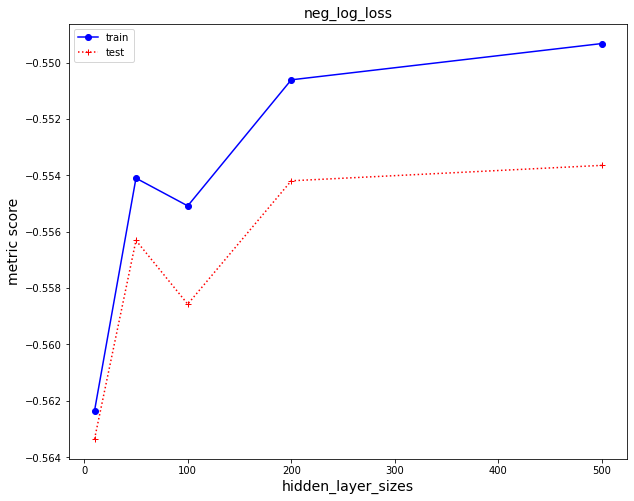

train accuracy score: [0.70907622 0.71546086 0.71221101 0.71807798 0.71784772]
test accuracy score: [0.70712339 0.71321832 0.71114776 0.71609419 0.71701552]


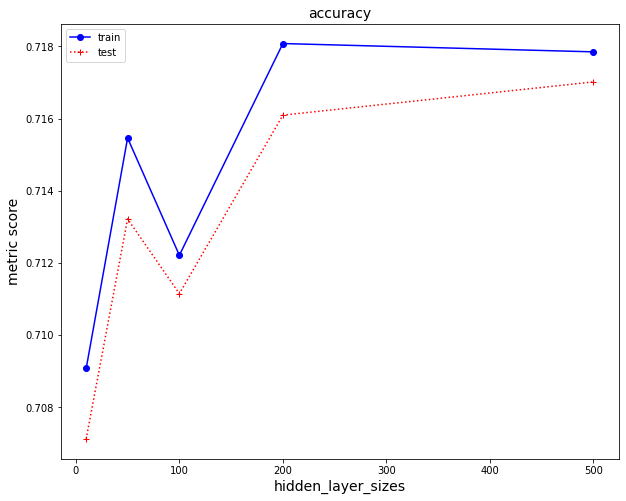

mean fit time: [2.90785675 3.54621968 3.13551173 5.02470975 9.35513453]


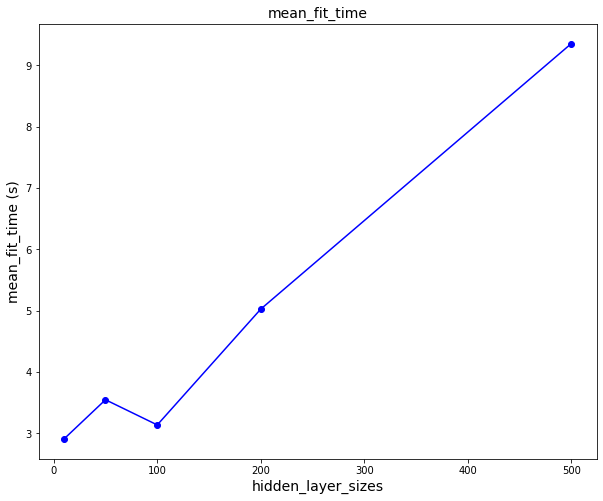

In [202]:
X0 = TruncatedSVD(2).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

# NN

train roc_auc score: [0.87678096 0.88266004 0.88326896 0.88463151 0.88713696]
test roc_auc score: [0.87513734 0.87886186 0.87924622 0.87942873 0.88056148]


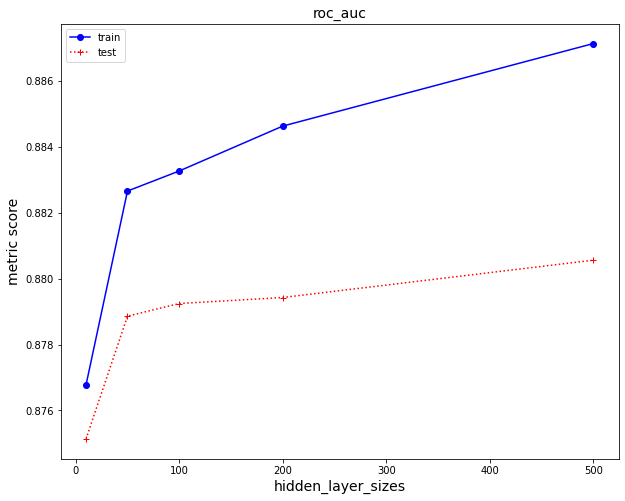

train neg_log_loss score: [-0.43355531 -0.42312479 -0.42203146 -0.41945594 -0.4141296 ]
test neg_log_loss score: [-0.43927344 -0.43272911 -0.43297136 -0.43249939 -0.43014099]


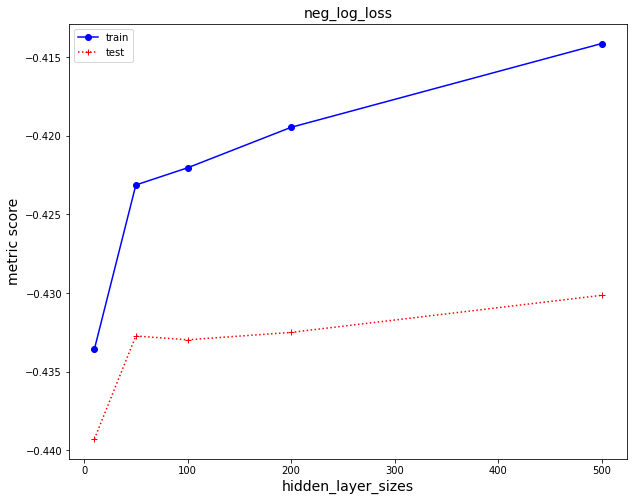

train accuracy score: [0.79411611 0.79687686 0.79748096 0.79840106 0.80098942]
test accuracy score: [0.7890272  0.79604478 0.79132737 0.79558514 0.79477981]


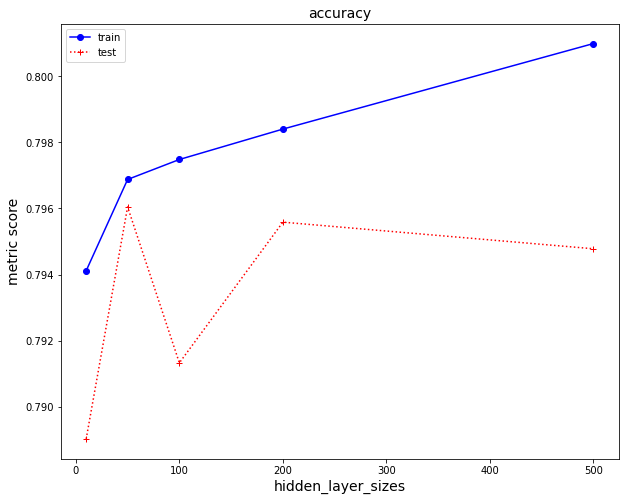

mean fit time: [ 2.11217718  3.17961764  3.62941031  5.03927555 11.53449421]


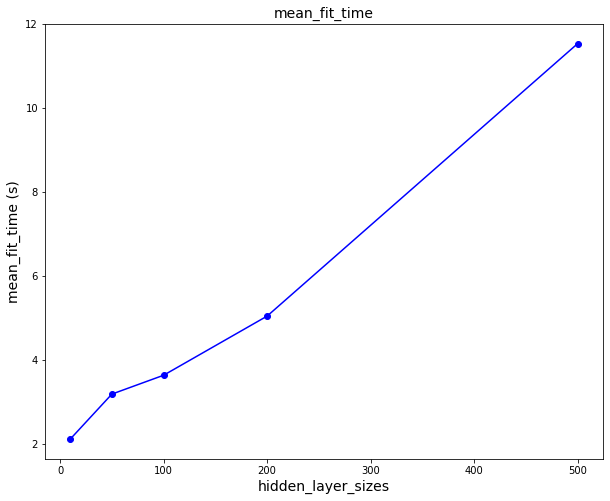

In [200]:
train_test(data, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])